蒸留検証

In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers.core import Activation

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
im_width = 128
im_height = 128
im_chan = 1
path_train = "./data/kaggle/train/"
path_test = './data/kaggle/test/'

In [3]:
# 特定のディレクトリのファイルをリストで読み込む
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [4]:
# test imgase , masks のサイズ変更
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)
print("Getting and resizing train images and masks ...")

#sys.stdout.flush()
# tqdm_notebook 進捗表示関数

for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    # 画像のロード
    img = load_img(path+"/images/"+id_)
    # RGBの3チャンネルとれるので1チャンネルを取得
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode="constant", preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + "/masks/" + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode="constant", preserve_range=True)

print("Done!")

Getting and resizing train images and masks ...


C:\Users\G2\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [5]:
# IoUメトリックを定義する
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [20]:
def theacher_model():
    # Bulid U-Net model
    # shape(128, 128, 1)
    inputs = Input((im_height, im_width, im_chan))
    # 画素値を0～1に変換
    s = Lambda(lambda x:x /255)(inputs)

    # フィルタ:(3✕3) フィルタ数:8
    # N_out = (N_in + 2P - F)/s +1 
    #          = (128 +0 - 2)/2 + 1 
    #          = 64
    tc1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    tc1 = Conv2D(8, (3, 3), activation='relu', padding='same') (tc1)
    tp1 = MaxPooling2D((2, 2)) (tc1)
    # shape(64,64,8)

    # N_in(64,64,8)
    tc2 = Conv2D(16, (3, 3), activation='relu', padding='same') (tp1)
    tc2 = Conv2D(16, (3, 3), activation='relu', padding='same') (tc2)
    tp2 = MaxPooling2D((2, 2)) (tc2)
    # N_out(32,32,16)

    tc3 = Conv2D(32, (3, 3), activation='relu', padding='same') (tp2)
    tc3 = Conv2D(32, (3, 3), activation='relu', padding='same') (tc3)
    tp3 = MaxPooling2D((2, 2)) (tc3)
    # N_out(16, 16, 32)

    tc4 = Conv2D(64, (3, 3), activation='relu', padding='same') (tp3)
    tc4 = Conv2D(64, (3, 3), activation='relu', padding='same') (tc4)
    tp4 = MaxPooling2D(pool_size=(2, 2)) (tc4)
    # N_out(8,8,64)

    tc5 = Conv2D(128, (3, 3), activation='relu', padding='same') (tp4)
    tc5 = Conv2D(128, (3, 3), activation='relu', padding='same') (tc5)
    # N_out(8, 8, 128)

    tu6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (tc5)
    tu6 = concatenate([tu6, tc4])
    tc6 = Conv2D(64, (3, 3), activation='relu', padding='same') (tu6)
    tc6 = Conv2D(64, (3, 3), activation='relu', padding='same') (tc6)
    # N_out(16,16, 64)

    tu7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (tc6)
    tu7 = concatenate([tu7, tc3])
    tc7 = Conv2D(32, (3, 3), activation='relu', padding='same') (tu7)
    tc7 = Conv2D(32, (3, 3), activation='relu', padding='same') (tc7)
    # N_out(32,32, 32)

    tu8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (tc7)
    tu8 = concatenate([tu8, tc2])
    tc8 = Conv2D(16, (3, 3), activation='relu', padding='same') (tu8)
    tc8 = Conv2D(16, (3, 3), activation='relu', padding='same') (tc8)
    # N_out(64, 64, 16)

    tu9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (tc8)
    # N_out(128, 128, 8)
    tu9 = concatenate([tu9, tc1], axis=3)
    tc9 = Conv2D(8, (3, 3), activation='relu', padding='same') (tu9)
    tc9 = Conv2D(8, (3, 3), activation='relu', padding='same') (tc9)

    tc10 = Conv2D(1, (1,1))(tc9)
    teacher_outputs = Activation('sigmoid')(tc10)
    
    return Model(inputs=[inputs], outputs=[teacher_outputs])

t_model = theacher_model()
t_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
t_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

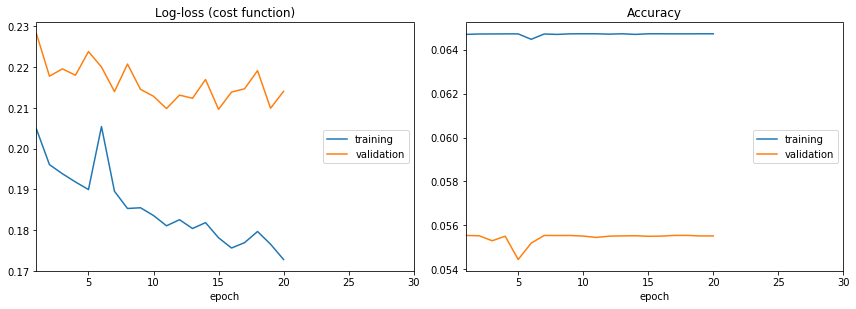

Log-loss (cost function):
training   (min:    0.173, max:    0.205, cur:    0.173)
validation (min:    0.210, max:    0.228, cur:    0.214)

Accuracy:
training   (min:    0.064, max:    0.065, cur:    0.065)
validation (min:    0.054, max:    0.056, cur:    0.056)
Epoch 00020: early stopping


In [22]:
from livelossplot.keras import PlotLossesCallback
earlystopper = EarlyStopping(patience=5, verbose=1)
#checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = t_model.fit(X_train, soft_target, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, PlotLossesCallback()])

In [24]:
t_model.save("teacher_model.h5")

# Soft Target 生成
学習済みの教師モデルをロードし、蒸留用に温度 T を出力層の前に追加

In [7]:
# モデル構築
# モデルをロード
from keras.models import load_model
teacher_model = load_model("teacher_model.h5")

# 重み固定
for i in range(len(teacher_model.layers)):
    teacher_model.layers[i].trainable = False
teacher_model.compile(optimizer="adam", loss="binary_crossentropy")

In [8]:
# 出力層を削除
teacher_model.layers.pop()

In [9]:
# 蒸留温度 T を1として Soft Target を生成
T = 1.0
input_layer = teacher_model.input

theacher_logits = teacher_model.layers[-1].output
theacher_logits_T = Lambda(lambda X: X/T)(theacher_logits)
teacher_probabilities_T = Activation('sigmoid')(theacher_logits_T)
teacher_model = Model(inputs=[input_layer], outputs=[teacher_probabilities_T])
teacher_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
teacher_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_13[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [10]:
# 重みをそのままでデータを生成、保存
soft_target = teacher_model.predict(X_train, verbose=1)
np.save("soft_target.npy", soft_target)

4000/4000 [==============================] - ETA: 5: - ETA: 53s - ETA: 28 - ETA: 19 - ETA: 15 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 1ms/step


In [6]:
soft_target = np.load("soft_target.npy")

In [13]:
from keras.losses import binary_crossentropy as logloss
lambda_ =  0.9
def knowledge_distillation_loss(input_distillation):
    y_pred, y_true, y_soft, y_pred_soft = input_distillation
    return (1 - lambda_) * logloss(y_true, y_pred) + lambda_*T*T*logloss(y_soft, y_pred_soft)
    #return 100 * logloss(y_true, y_pred) + lambda_*T*T*logloss(y_soft, y_pred_soft)

In [38]:
del inputs

# 生徒モデル作成

In [7]:
T = 1.0
# 生徒モデル
# フィルタ:(3✕3) フィルタ数:8
# N_out = (N_in + 2P - F)/s +1 
#          = (128 +0 - 2)/2 + 1 
#          = 64
inputs = Input((im_height, im_width, im_chan))
# 画素値を0～1に変換
s = Lambda(lambda x:x /255)(inputs)

# フィルタ:(3✕3) フィルタ数:8
# N_out = (N_in + 2P - F)/s +1 
#          = (128 +0 - 2)/2 + 1 
#          = 64
tc1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
#tc1 = Conv2D(8, (3, 3), activation='relu', padding='same') (tc1)
tp1 = MaxPooling2D((2, 2)) (tc1)
# shape(64,64,8)

# N_in(64,64,8)
tc2 = Conv2D(16, (3, 3), activation='relu', padding='same') (tp1)
#tc2 = Conv2D(16, (3, 3), activation='relu', padding='same') (tc2)
tp2 = MaxPooling2D((2, 2)) (tc2)
# N_out(32,32,16)

tc3 = Conv2D(32, (3, 3), activation='relu', padding='same') (tp2)
#tc3 = Conv2D(32, (3, 3), activation='relu', padding='same') (tc3)
tp3 = MaxPooling2D((2, 2)) (tc3)
# N_out(16, 16, 32)

tc4 = Conv2D(64, (3, 3), activation='relu', padding='same') (tp3)
#tc4 = Conv2D(64, (3, 3), activation='relu', padding='same') (tc4)
tp4 = MaxPooling2D(pool_size=(2, 2)) (tc4)
# N_out(8,8,64)

#tc5 = Conv2D(128, (3, 3), activation='relu', padding='same') (tp4)
#tc5 = Conv2D(128, (3, 3), activation='relu', padding='same') (tc5)
# N_out(8, 8, 128)

#tu6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (tc5)
#tu6 = concatenate([tu6, tc4])
#tc6 = Conv2D(64, (3, 3), activation='relu', padding='same') (tu6)
#tc6 = Conv2D(64, (3, 3), activation='relu', padding='same') (tc6)
# N_out(16,16, 64)

tu7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (tc4)
tu7 = concatenate([tu7, tc3])
tc7 = Conv2D(32, (3, 3), activation='relu', padding='same') (tu7)
#tc7 = Conv2D(32, (3, 3), activation='relu', padding='same') (tc7)
# N_out(32,32, 32)

tu8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (tc7)
tu8 = concatenate([tu8, tc2])
tc8 = Conv2D(16, (3, 3), activation='relu', padding='same') (tu8)
#tc8 = Conv2D(16, (3, 3), activation='relu', padding='same') (tc8)
# N_out(64, 64, 16)

tu9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (tc8)
# N_out(128, 128, 8)
tu9 = concatenate([tu9, tc1], axis=3)
tc9 = Conv2D(8, (3, 3), activation='relu', padding='same') (tu9)
#tc9 = Conv2D(8, (3, 3), activation='relu', padding='same') (tc9)

tc10 = Conv2D(1, (1,1))(tc9)
output = Activation('sigmoid')(tc10)
#logits_T =Lambda(lambda X: X/T)(c11)
#probabilities_T  = Activation("sigmoid", name="probabilities_T")(logits_T)

student_model = Model(inputs=[inputs], outputs=[output])
student_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
student_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

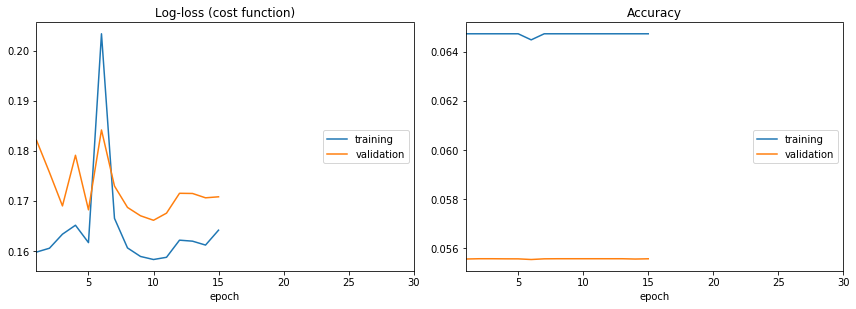

Log-loss (cost function):
training   (min:    0.158, max:    0.203, cur:    0.164)
validation (min:    0.166, max:    0.184, cur:    0.171)

Accuracy:
training   (min:    0.064, max:    0.065, cur:    0.065)
validation (min:    0.056, max:    0.056, cur:    0.056)
Epoch 00015: early stopping


In [32]:
earlystopper = EarlyStopping(patience=5, verbose=1)
results = teacher_model.fit(X_train, soft_target, validation_split=0.1, epochs=30, batch_size=8, callbacks=[PlotLossesCallback(),earlystopper])

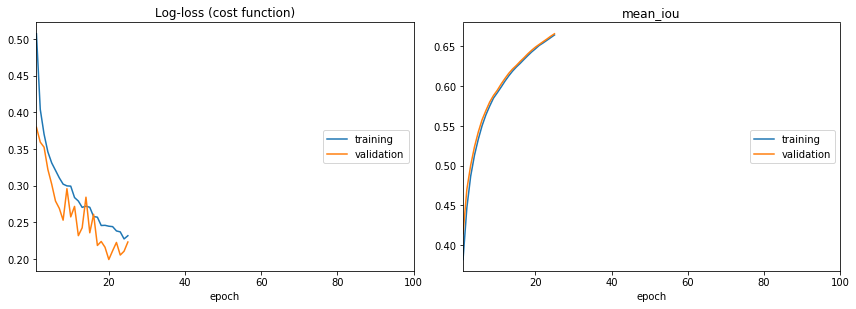

Log-loss (cost function):
training   (min:    0.227, max:    0.507, cur:    0.232)
validation (min:    0.199, max:    0.380, cur:    0.223)

mean_iou:
training   (min:    0.382, max:    0.664, cur:    0.664)
validation (min:    0.414, max:    0.666, cur:    0.666)
Epoch 00025: early stopping


In [8]:
from livelossplot.keras import PlotLossesCallback
earlystopper = EarlyStopping(patience=5, verbose=1)
results = student_model.fit(X_train, Y_train, epochs=100, batch_size=8, validation_split=0.1, callbacks=[PlotLossesCallback(), earlystopper])

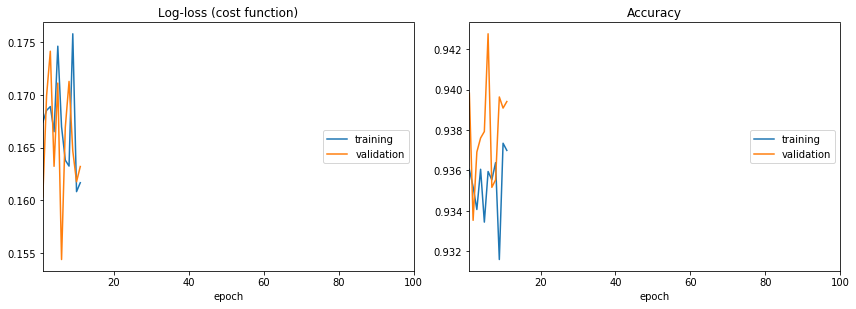

Log-loss (cost function):
training   (min:    0.161, max:    0.176, cur:    0.162)
validation (min:    0.154, max:    0.174, cur:    0.163)

Accuracy:
training   (min:    0.932, max:    0.937, cur:    0.937)
validation (min:    0.934, max:    0.943, cur:    0.939)
Epoch 00011: early stopping


In [27]:
from livelossplot.keras import PlotLossesCallback
earlystopper = EarlyStopping(patience=5, verbose=1)
results = student_model2.fit(X_train, Y_train, epochs=100, batch_size=8, validation_split=0.1, callbacks=[PlotLossesCallback(), earlystopper])

In [30]:
# 生徒モデル
with tf.device('/cpu:0'):
    student_model = Model(inputs=inputs, outputs=output)
    input_true = Input(name='input_true', shape=[128,128,1], dtype='float32')

# モデル全体
output_loss = Lambda(knowledge_distillation_loss, output_shape=(1,), name='kd_')(
    [output, input_true, teacher_probabilities_T, probabilities_T]
)
inputs = [input_layer, input_true] 
with tf.device('/cpu:0'):
    train_model = Model(inputs=[input_layer], outputs=[output_loss])
    #train_model = Model(inputs=inputs, outputs=output_loss)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_3:0", shape=(?, 128, 128, 1), dtype=float32) at layer "input_3". The following previous layers were accessed without issue: ['input_1']

In [13]:
from tensorflow.python.client import device_lib
def convert_gpu_model(org_model: Model) -> Model:
    gpu_count = len(device_lib.list_local_devices()) - 1
    if gpu_count > 1:
        train_model = multi_gpu_model(org_model, gpu_count)
    else:
        train_model = org_model
    return train_model

train_model = convert_gpu_model(train_model)

In [14]:
from keras.optimizers import Adam
#keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#train_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss=lambda y_true, y_pred: y_pred)
train_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss=lambda y_true, y_pred: output_loss)
#train_model.compile(optimizer='adam', loss= lambda y_true, y_pred: y_pred)

In [16]:
import keras
tb_cb = keras.callbacks.TensorBoard(log_dir="./tflog/", histogram_freq=1)
cbks = [tb_cb]

In [18]:
from livelossplot.keras import PlotLossesCallback
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs.h5', verbose=1, save_best_only=True)
results = train_model.fit([X_train, Y_train], Y_train, validation_split=0.1, epochs=30, batch_size=8, callbacks=[PlotLossesCallback()])
#results = train_model.fit([X_train, Y_train], Y_train, validation_split=0.1, epochs=5, batch_size=100, callbacks=cbks)

Train on 3600 samples, validate on 400 samples
Epoch 1/5
3600/3600 [==============================] - ETA: 56s - loss: -5.321 - ETA: 29s - loss: -6.245 - ETA: 20s - loss: -6.613 - ETA: 16s - loss: -6.254 - ETA: 13s - loss: -6.147 - ETA: 11s - loss: -6.151 - ETA: 10s - loss: -5.969 - ETA: 9s - loss: -5.917 - ETA: 8s - loss: -5.83 - ETA: 7s - loss: -5.90 - ETA: 6s - loss: -5.99 - ETA: 6s - loss: -5.98 - ETA: 5s - loss: -6.01 - ETA: 5s - loss: -5.96 - ETA: 4s - loss: -6.00 - ETA: 4s - loss: -5.96 - ETA: 4s - loss: -5.88 - ETA: 3s - loss: -5.89 - ETA: 3s - loss: -5.90 - ETA: 3s - loss: -5.99 - ETA: 3s - loss: -6.01 - ETA: 2s - loss: -6.06 - ETA: 2s - loss: -6.01 - ETA: 2s - loss: -6.02 - ETA: 2s - loss: -6.00 - ETA: 1s - loss: -5.99 - ETA: 1s - loss: -5.97 - ETA: 1s - loss: -6.00 - ETA: 1s - loss: -5.95 - ETA: 1s - loss: -5.97 - ETA: 0s - loss: -5.97 - ETA: 0s - loss: -6.00 - ETA: 0s - loss: -5.98 - ETA: 0s - loss: -6.02 - ETA: 0s - loss: -6.03 - 7s 2ms/step - loss: -6.0683 - val_loss: -6.

ValueError: Cannot feed value of shape (32, 128, 128, 1) for Tensor 'kd__target:0', which has shape '(?, ?)'

In [ ]:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.1,  # set range for random shear
        zoom_range=0.2,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None)

datagen.fit(X_train)

In [17]:
from keras.utils import plot_model
plot_model(train_model, to_file='model.png')

In [18]:
plot_model(train_model, to_file='student.png')

In [23]:
student_model.save("student.h5")

In [ ]:
train_model.save("train_model.h5")

In [14]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + "/images/" + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode="constant", preserve_range=True)
    X_test[n] = x
    
print("Done!")

Getting and resizing test images ... 



Done!


In [11]:
student_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_train = student_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = student_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = student_model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

400/400 [==============================] - ETA:  - ETA:  - 0s 292us/step


In [29]:
student_model2.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_train2 = student_model2.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val2 = student_model2.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test2 = student_model2.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t2 = (preds_train2 > 0.5).astype(np.uint8)
preds_val_t2 = (preds_val2 > 0.5).astype(np.uint8)
preds_test_t2 = (preds_test2 > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 303us/step


In [18]:
# Create list of upsampled test masks
preds_test_upsampled2 = []
for i in tnrange(len(preds_test2)):
    preds_test_upsampled2.append(resize(np.squeeze(preds_test2[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

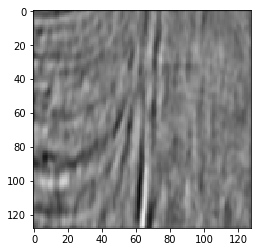

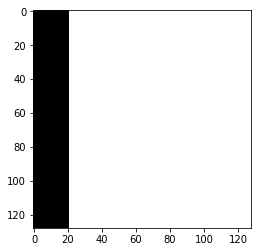

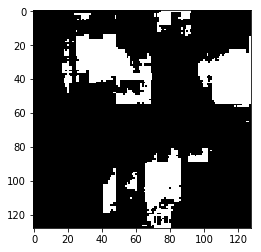

In [14]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [15]:
ix

2847

In [41]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [42]:
preds_test_upsampled[0].shape

(101, 101)

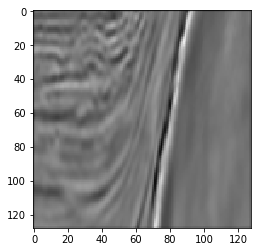

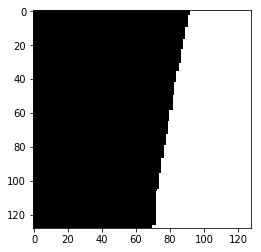

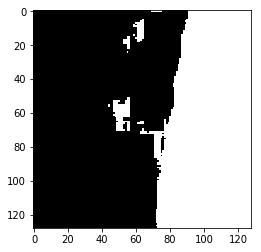

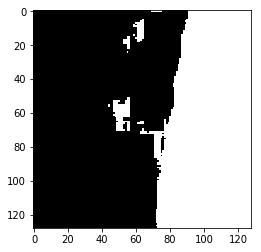

In [24]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t2[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()